In [ ]:
#=using Pkg;

Pkg.add("Lazy");
Pkg.add("JSON");
Pkg.add("VegaLite");
Pkg.add("Query");
Pkg.add("DataFrames");=#

In [1]:
using Lazy: @>, @>>, @as;
import JSON;
using VegaLite;
using DelimitedFiles;
using Query;

In [2]:
cognitive_complexity_top500_file = "churn v. complexity/cognitive_complexity_top500.json";
most_changed_files_last_12months_file = "churn v. complexity/most_changed_files_last_12months.txt";

In [2]:
cc_raw = JSON.parsefile(cognitive_complexity_top500_file);

In [3]:
parse_cc_field(dict) = dict["cognitive_complexity"] = @>> dict["cognitive_complexity"] parse(Int32)
# side effecting map below
@>> cc_raw map(parse_cc_field);

In [4]:
using DataFrames

In [5]:
dicts_to_df(dicts) = vcat(DataFrame.(dicts)...);

In [6]:
cc_df = dicts_to_df(cc_raw);

In [7]:
churn_raw = readdlm(most_changed_files_last_12months_file, ' ', String, '\n');

In [8]:
churn_row_to_dict(row) = Dict("changes"=>parse(Int32,row[1]), "path"=>row[2])
changes_df = @>> eachrow(churn_raw) map(churn_row_to_dict) dicts_to_df;

In [9]:
df_pre1 = @> join(changes_df, cc_df, on=:path) sort!([:changes, :cognitive_complexity], rev=true);

In [10]:
df_pre1;

In [11]:
extract_subproject(path) = match(r"^(.+)\/src", path).captures[1];

Tag paths based on whether or not they contain interesting directories:

In [27]:
tag(path) = begin
    in_path(str) = occursin(str, path)
    if in_path("/desktop/")
        "desktop"
    elseif in_path("/trade/")
        "trade"
    elseif in_path("/dao/")
        "dao"
    elseif in_path("/btc/")
        "btc"
    elseif in_path("/offer/")
        "offer"
    elseif in_path("/p2p/")
        "p2p"
    else
        "[untagged]"
    end;
end;

In [13]:
extract_shorter_path(path) = match(r"^.+\/java\/(.+)$", path).captures[1];

In [14]:
examined_path_df =
    by(df_pre1, :path,
        :path => paths -> (
            subproject=map(extract_subproject, paths),
            shorter_path=map(extract_shorter_path, paths),
            tag=map(tag, paths),
        )
    );

In [15]:
df = @> join(df_pre1, examined_path_df, on=:path) select(Not(:path));

## Dataset

The dataset is the intersection between 500 source files with highest cognitive complexity (as extracted from SonarQube) and the files that received changes during the last 12 months (as extracted from Git). The features are cognitive complexity, number of changes during last 12 months, and file path (which is refined into features "subproject", "shorter_path" and "tag").

_Note_: explanation of box plots can be found here: https://vega.github.io/vega-lite/docs/boxplot.html

In [30]:
df |>
@filter(_.subproject != "desktop") |>
@filter(_.cognitive_complexity >= 10) |>
@filter(_.changes >= 4) |>
@orderby(_.shorter_path) |>
DataFrame

,changes,cognitive_complexity,subproject,shorter_path,tag
,Int32,Int32,SubStrin…,SubStrin…,String
1,88,32,common,bisq/common/config/Config.java,[untagged]
2,14,29,common,bisq/common/storage/FileManager.java,[untagged]
3,4,13,common,bisq/common/storage/Storage.java,[untagged]
4,4,11,common,bisq/common/util/PermutationUtil.java,[untagged]
5,11,34,core,bisq/core/account/sign/SignedWitnessService.java,[untagged]
6,11,70,core,bisq/core/account/witness/AccountAgeWitnessService.java,[untagged]
7,6,31,core,bisq/core/alert/AlertManager.java,[untagged]
8,6,52,core,bisq/core/app/AvoidStandbyModeService.java,[untagged]
9,78,12,core,bisq/core/app/BisqExecutable.java,[untagged]


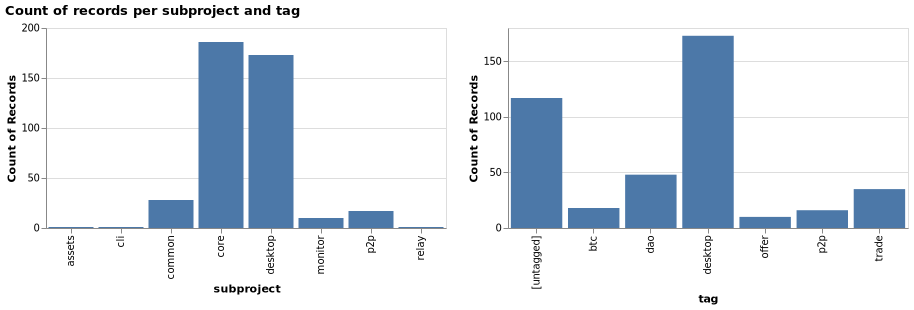

In [19]:
df |>
@vlplot(
    title="Count of records per subproject and tag",
    repeat={column=[:subproject, :tag]}) +
@vlplot(
    :bar,
    width=400,
    x={field={repeat=:column},type=:nominal},
    y="count()",
)

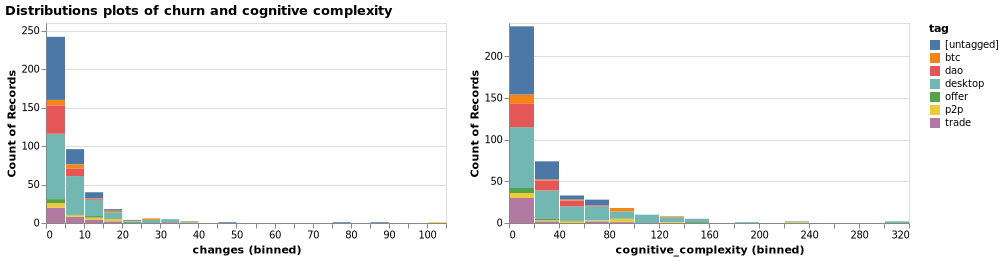

In [20]:
df |>
@vlplot(
    title="Distributions plots of churn and cognitive complexity",
    repeat={column=[:changes, :cognitive_complexity]}
) +
@vlplot(
    :bar,
    width=400,
    x={field={repeat=:column},bin={maxbins=30},type=:quantitative},
    y="count()",
    color=:tag,
)

In [21]:
plot_x_v_y(x,y,title) = @vlplot(
    title=title,
    width=400,
    mark={:boxplot, extent=1.5},
    encoding={
        x=x,
        y=y,
    },
);

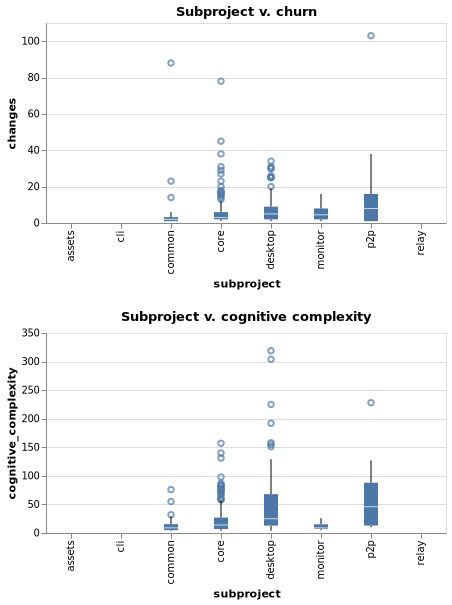

In [22]:
df |>
@vlplot() + [
plot_x_v_y("subproject:n", "changes:q", "Subproject v. churn");
plot_x_v_y("subproject:n", "cognitive_complexity:q", "Subproject v. cognitive complexity");
]

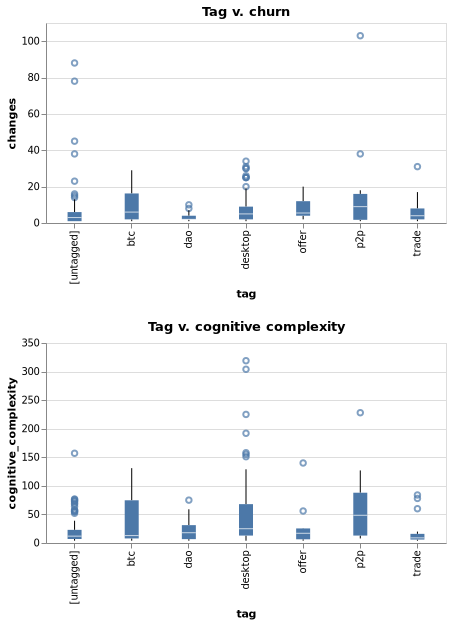

In [23]:
df |>
@vlplot() + [
plot_x_v_y("tag:n", "changes:q", "Tag v. churn");
plot_x_v_y("tag:n", "cognitive_complexity:q", "Tag v. cognitive complexity")
]

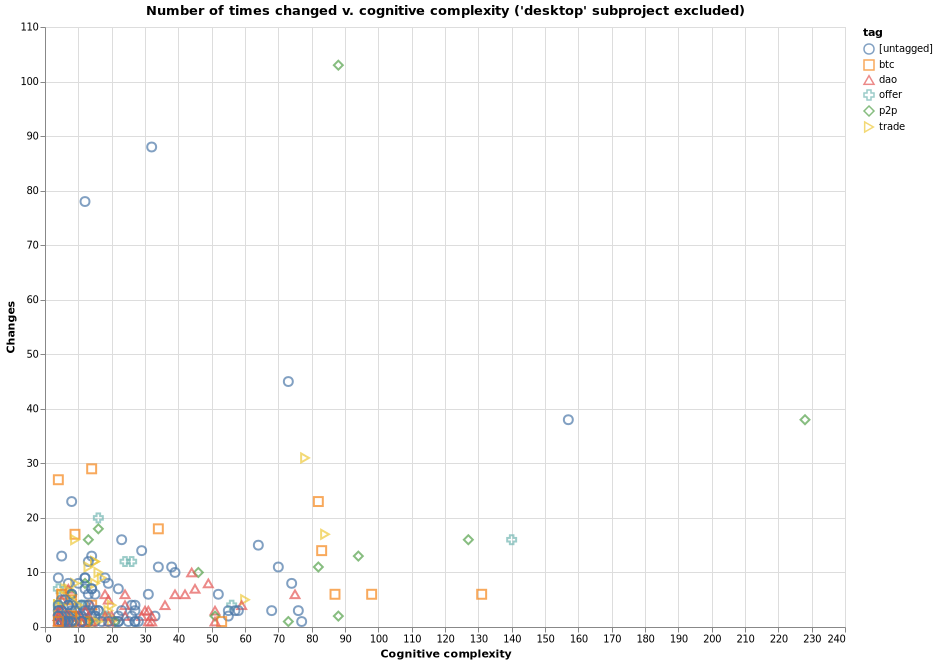

In [24]:
changes_vs_cc_plot(title) = @vlplot(
    title=title,
    mark={type=:point, size=80, strokeWidth=2},
    height=600,
    width=800,
    x={
        :cognitive_complexity,
        title="Cognitive complexity",
        # scale={type=:log},
        },
    y={
        :changes,
        title="Changes",
        # scale={type=:log},
        },
    color="tag:n",
    shape="tag:n",
    tooltip={field=:shorter_path, type="nominal"},
)

p = df |>
    @filter(_.subproject != "desktop") |>
    #@filter(_.tag != ) |>
    DataFrame |>
    changes_vs_cc_plot("Number of times changed v. cognitive complexity ('desktop' subproject excluded)")

To use the tooltip, open `figure.vegalite` in JupyterLab (otherwise examine the table):

In [25]:
p |> save("churn v. complexity/figure.vegalite")

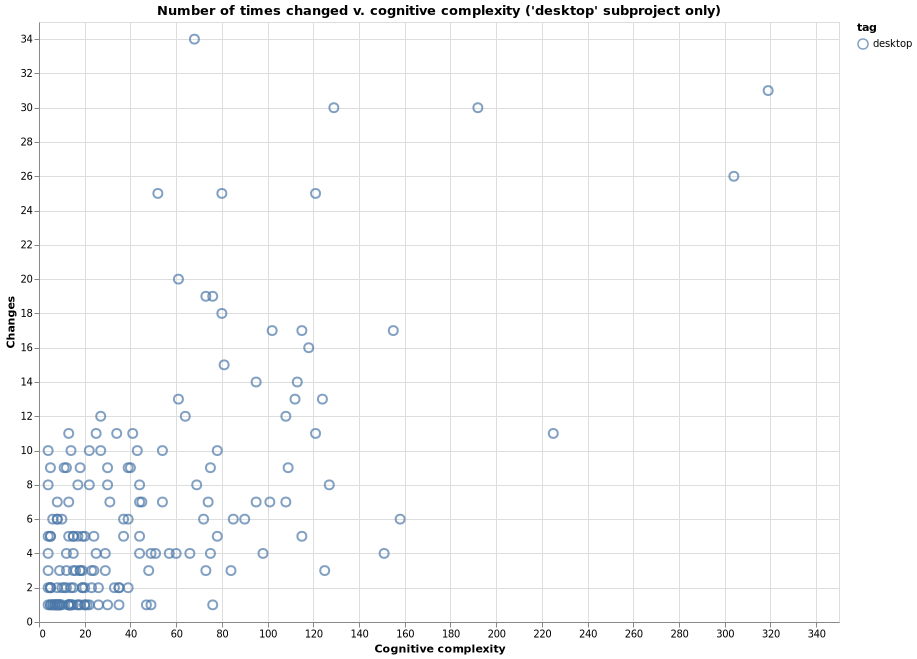

In [26]:
df |>
    @filter(_.subproject == "desktop") |>
    #@filter(_.tag != ) |>
    DataFrame |>
    changes_vs_cc_plot("Number of times changed v. cognitive complexity ('desktop' subproject only)")